<a href="https://colab.research.google.com/github/JamesUMD/Kaggle/blob/main/Tweets/Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Purpose of this Kaggle Competition 


In [109]:
#Import of Libraries

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from collections import  Counter
import gensim
import string
import re
from tqdm import tqdm

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Nueral Networks
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, Dropout
from keras.initializers import Constant
from sklearn.model_selection import train_test_split

#NLP
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [110]:
#import of Data
train = pd.read_csv('https://raw.githubusercontent.com/JamesUMD/Kaggle/main/Tweets/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/JamesUMD/Kaggle/main/Tweets/test.csv')
train.info()
test.info()

print(train.head(10))
print(test.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
   id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Fores

In [111]:
#creates combined dataset for feature engineerings

data = [train,test]
df = pd.concat(data)

**Data Cleansing**


---



In [112]:
# Null Values 

print('Train Columns with null values:\n', train.isnull().sum())
print('Test Columns with null values:\n', test.isnull().sum())

Train Columns with null values:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Test Columns with null values:
 id             0
keyword       26
location    1105
text           0
dtype: int64


In [113]:
#Since there are missing values in both keyword and location, we wont drop data however we will fill in the text with no missing_per col

for dfs in data:
    for col in ['keyword','location']:
        dfs[col] = dfs[col].fillna(f'missing_{col}')

#Check Missing Values Again
print('Train Columns with null values:\n', train.isnull().sum())
print('Test Columns with null values:\n', test.isnull().sum())

Train Columns with null values:
 id          0
keyword     0
location    0
text        0
target      0
dtype: int64
Test Columns with null values:
 id          0
keyword     0
location    0
text        0
dtype: int64


**Data Exploration**

---



Text(0, 0.5, 'Target')

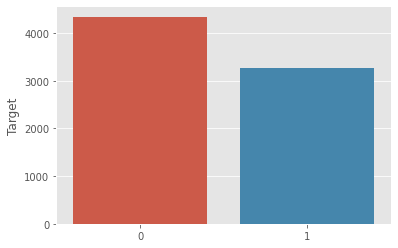

In [114]:
#Class distribution

dis = train.target.value_counts()
sns.barplot(dis.index, dis)
plt.gca().set_ylabel('Target')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


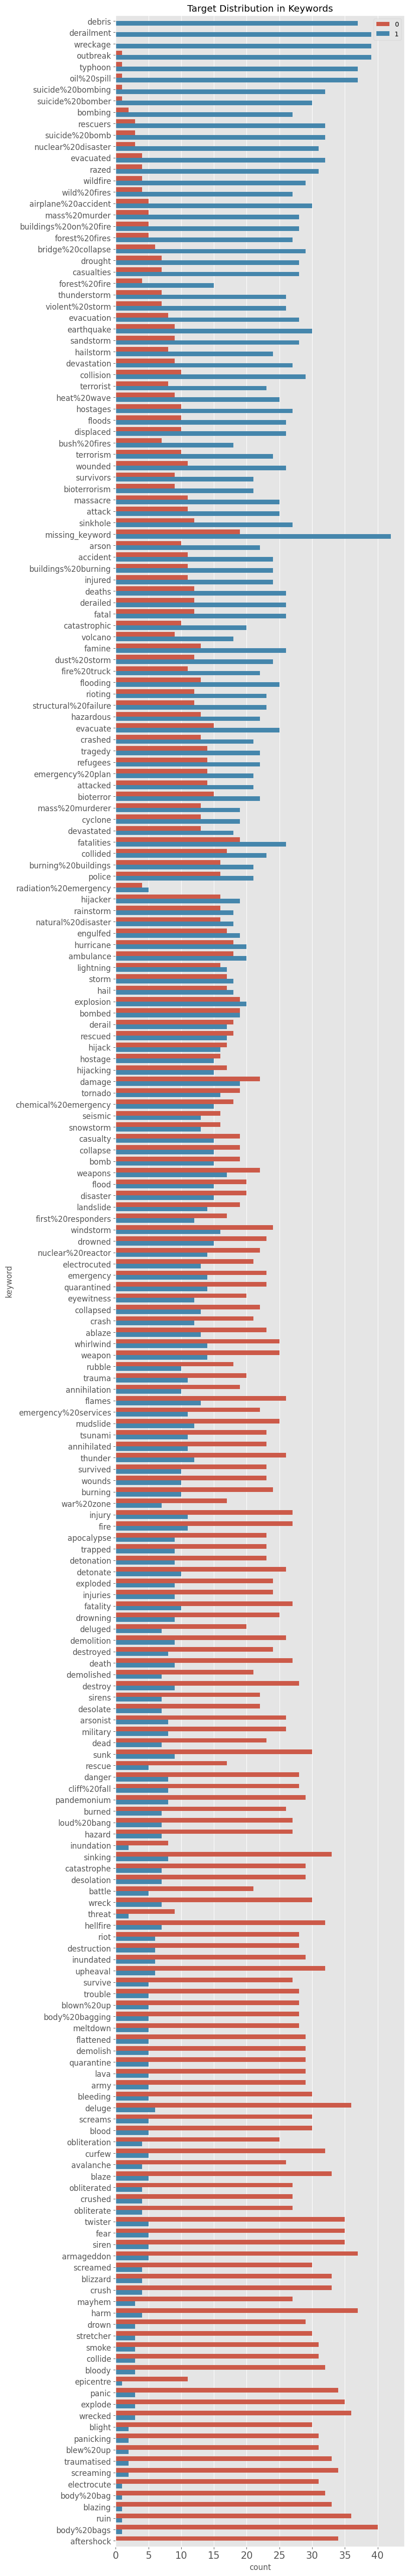

In [115]:
# Word Distrubution

print(f'Number of unique values in keyword = {train["keyword"].nunique()} (Training) - {test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {train["location"].nunique()} (Training) - {test["location"].nunique()} (Test)')


train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)

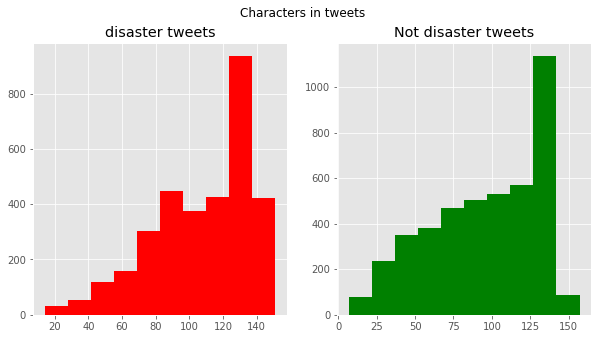

In [116]:
# Character Count
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.len()
ax1.hist(train_len,color='red')
ax1.set_title('disaster tweets')
train_len=train[train['target']==0]['text'].str.len()
ax2.hist(train_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()


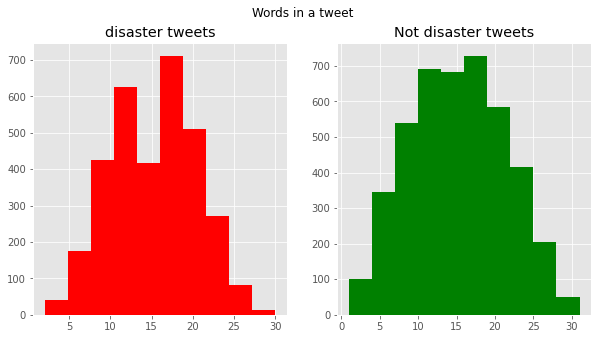

In [117]:
# Word Sistribution

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color='red')
ax1.set_title('disaster tweets')
train_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

In [118]:
# Corpus Creation
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus



<BarContainer object of 10 artists>

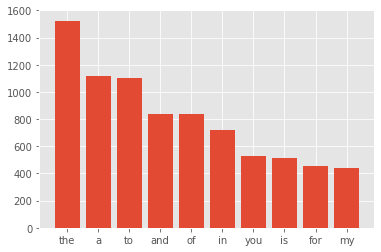

In [119]:
# Stop Word Distribution

corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 18 artists>

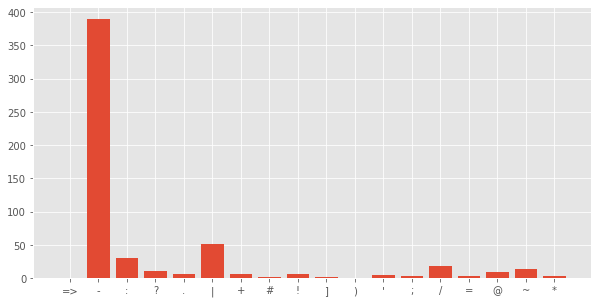

In [120]:
#Special Characters and Puncuation

plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

**Text Cleansing**


---



In [121]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [122]:
for dfs in data: 
    dfs['text'] = dfs['text'].apply(lambda x : remove_URL(x))
    dfs['text'] = dfs['text'].apply(lambda x : remove_html(x))
    dfs['text'] = dfs['text'].apply(lambda x : remove_emoji(x))
    dfs['text'] = dfs['text'].apply(lambda x : remove_punct(x))

**Model**


---



In [123]:
#Vector

def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:02<00:00, 3834.03it/s]


In [124]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [125]:
maxlength = 50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=maxlength,truncating='post',padding='post')

word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 18694


In [126]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 18694/18694 [00:00<00:00, 494200.19it/s]


In [127]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=maxlength,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [128]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           1869500   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,911,805
Trainable params: 42,305
Non-trainable params: 1,869,500
_________________________________________________________________


In [129]:
train2 = tweet_pad[:train.shape[0]]
testy = tweet_pad[train.shape[0]:]

In [130]:
X_train,X_test,y_train,y_test=train_test_split(train2,train['target'].values,test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6090, 50)
Shape of Validation  (1523, 50)


In [131]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)


Epoch 1/15
1523/1523 - 75s - loss: 0.6909 - accuracy: 0.5722 - val_loss: 0.6877 - val_accuracy: 0.5607
Epoch 2/15
1523/1523 - 71s - loss: 0.6047 - accuracy: 0.6839 - val_loss: 0.5580 - val_accuracy: 0.7466
Epoch 3/15
1523/1523 - 71s - loss: 0.5491 - accuracy: 0.7389 - val_loss: 0.5348 - val_accuracy: 0.7557
Epoch 4/15
1523/1523 - 71s - loss: 0.5268 - accuracy: 0.7568 - val_loss: 0.5197 - val_accuracy: 0.7564
Epoch 5/15
1523/1523 - 72s - loss: 0.5138 - accuracy: 0.7650 - val_loss: 0.5116 - val_accuracy: 0.7610
Epoch 6/15
1523/1523 - 71s - loss: 0.5101 - accuracy: 0.7662 - val_loss: 0.5037 - val_accuracy: 0.7663
Epoch 7/15
1523/1523 - 72s - loss: 0.5015 - accuracy: 0.7737 - val_loss: 0.4974 - val_accuracy: 0.7695
Epoch 8/15
1523/1523 - 71s - loss: 0.4940 - accuracy: 0.7773 - val_loss: 0.4934 - val_accuracy: 0.7741
Epoch 9/15
1523/1523 - 72s - loss: 0.4905 - accuracy: 0.7790 - val_loss: 0.4904 - val_accuracy: 0.7774
Epoch 10/15
1523/1523 - 72s - loss: 0.4900 - accuracy: 0.7760 - val_loss: